# Semestral project for MFF UK - Marketing

In [419]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram,linkage,fcluster

from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler,OneHotEncoder

from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss

from sklearn.linear_model import LinearRegression,LogisticRegression,Ridge
from sklearn.tree import DecisionTreeClassifier,export_text, DecisionTreeRegressor

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier

from mlxtend.plotting import plot_decision_regions

from IPython.display import display, HTML

***The dataset we will be working with can be found at:*** [Kaggle](https://www.kaggle.com/datasets/imakash3011/customer-personality-analysis)

*Github of the project is currently private, but will be published once it is finished*

### About the dataset

It is concerned with the results of a broad marketing campaign across more than 2000 participants. The dataset includes some metadata about the respondents familial background - such as Income, Marital status, or whether there are teenagers living in the household - and details about the purchased data - whether the products were bought as a part of a deal, their quantities, and others. We will be analysing this dataset in a comprehensive manner, examining different quantities, looking for correlations, identifying different groups of citizens that are more prone to certain products, and more.

Now, let us finally open our data:

In [420]:
campaign = pd.read_csv('data/marketing_campaign.csv', sep='\t')
campaign.fillna(campaign.median(numeric_only=True).round(0), inplace=True)
campaign.head(10)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0
5,7446,1967,Master,Together,62513.0,0,1,09-09-2013,16,520,...,6,0,0,0,0,0,0,3,11,0
6,965,1971,Graduation,Divorced,55635.0,0,1,13-11-2012,34,235,...,6,0,0,0,0,0,0,3,11,0
7,6177,1985,PhD,Married,33454.0,1,0,08-05-2013,32,76,...,8,0,0,0,0,0,0,3,11,0
8,4855,1974,PhD,Together,30351.0,1,0,06-06-2013,19,14,...,9,0,0,0,0,0,0,3,11,1
9,5899,1950,PhD,Together,5648.0,1,1,13-03-2014,68,28,...,20,1,0,0,0,0,0,3,11,0


Now that our data is loaded, let us see gow many respondents there actually are, as well as examine the distributions of education, of marital status, and of kid amounts, to get a rough idea with what groups of people we are dealing with.

There are 2240 entries and 29 columns


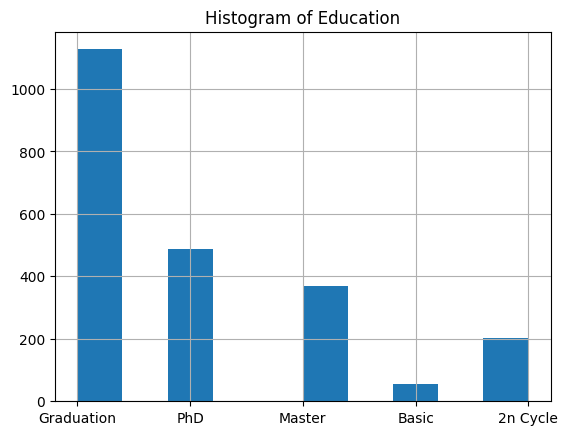

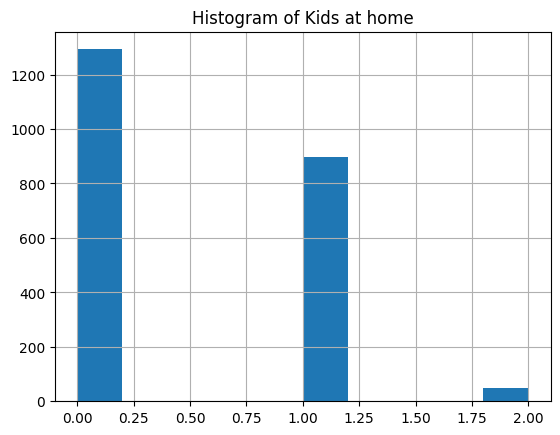

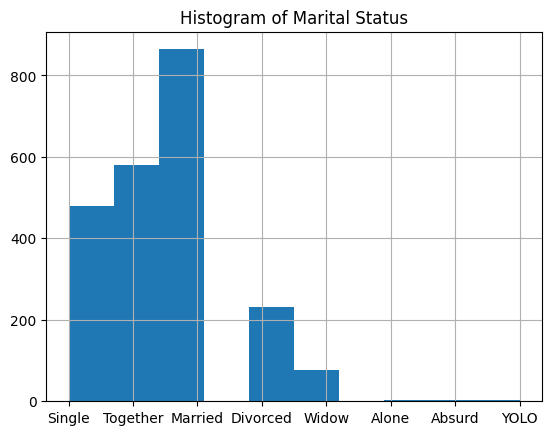

In [421]:
print('There are {} entries and {} columns'.format(campaign.shape[0], campaign.shape[1]))
ed_hist = campaign['Education'].hist()
plt.title('Histogram of Education')
plt.show()

kids_hist = campaign['Kidhome'].hist()
plt.title('Histogram of Kids at home')
plt.show()

ed_hist = campaign['Marital_Status'].hist()
plt.title('Histogram of Marital Status')
plt.show()

And manually for income:

In [422]:
np.max(campaign['Income'])

666666.0

(array([1678,  554,    7,    0,    0,    0,    0,    0,    0,    1],
      dtype=int64), array([  1730. ,  68223.6, 134717.2, 201210.8, 267704.4, 334198. ,
       400691.6, 467185.2, 533678.8, 600172.4, 666666. ]))


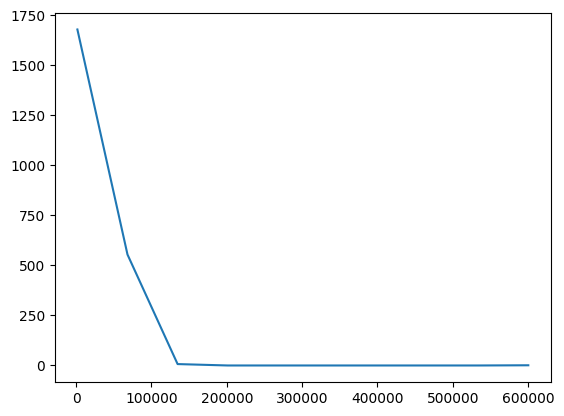

In [423]:
bins = [10**i for i in range(1,5)]
inc_hist = np.histogram(campaign['Income'])
print(inc_hist)

plt.plot(inc_hist[1][:-1], inc_hist[0])
plt.show()

As expected, Income follows the famous Pareto distribution, having a handful of disproportianetly high-earners with the majority at the bottom.

*Note that we attempted to plot the bar of this income distribution, but the bar did not show.*

To make matters a little cleaner, we will from now on treat the data as if our single super-high income individual didn't exist, as he will skew the data disproportianately.

In [424]:
campaign = campaign.drop(campaign.index[campaign['Income'] == 666666.0])

Let us now compare the amount of teenagers versus kids our respondents are responsible for.

Text(0.5, 1.0, 'Respondent family situation')

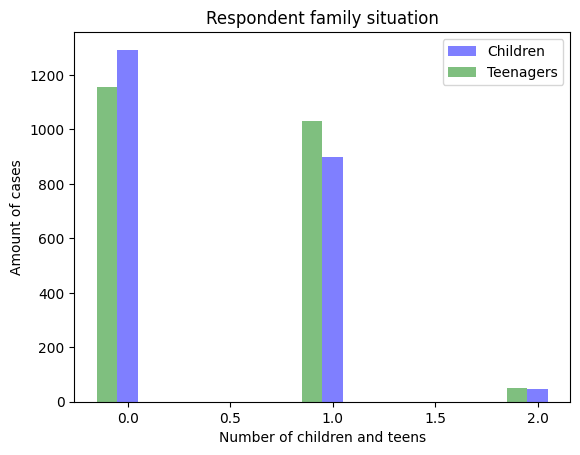

In [425]:
kid_values= list(set(campaign['Kidhome']))
kid_values.sort()
bb=[0]+[i+0.1 for i in kid_values]
plt.bar(kid_values, np.histogram(campaign['Kidhome'], bins=bb)[0], width=0.1, alpha=0.5, color='blue', label='Children')
plt.bar([(i-0.1) for i in kid_values], np.histogram(campaign['Teenhome'], bins=bb)[0], width=0.1, alpha=0.5, color='green', label='Teenagers')
plt.xlabel('Number of children and teens')
plt.ylabel('Amount of cases')
plt.legend()
plt.title('Respondent family situation')

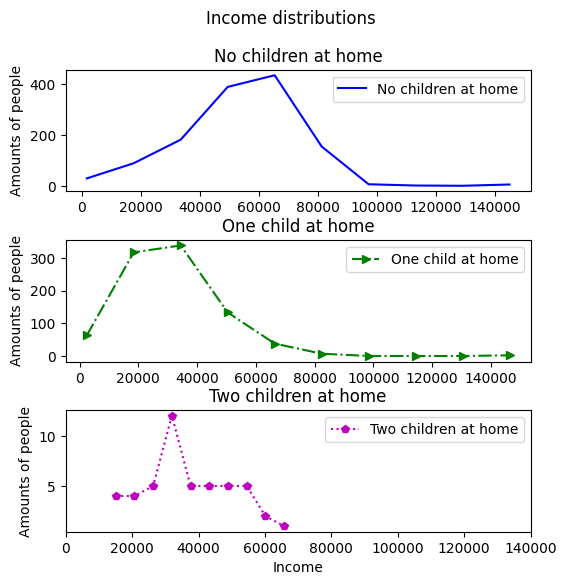

In [426]:
def ukaz(ax,data,text, color):
    plt.title(text)
    inc_hist = np.histogram(data['Income'])

    plt.plot(inc_hist[1][:-1], inc_hist[0], color, label=text)
    plt.legend()
    plt.ylabel('Amounts of people')

no_kid = campaign['Kidhome'] == 0
one_kid = campaign['Kidhome'] == 1
two_kid = campaign['Kidhome'] == 2

fig, ax_lst = plt.subplots(3, 1, figsize=(6, 6))  # 3 rows, 1 column; numbered row-wise
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle('Income distributions')  # Add a title so we know which it is
plt.xlim([0, 140000])
sub1=plt.subplot(311)
ukaz(plt, campaign[no_kid],'No children at home','-b')
ax2=plt.subplot(312)
ukaz(plt, campaign[one_kid],'One child at home','>-.g')
plt.subplot(313)
ukaz(plt, campaign[two_kid],'Two children at home','p:m')
plt.xlabel('Income')
plt.show()

We can easily see that groups of respondents with no or one child are typically higher income than households with two children, which is paradoxical. One would perhaps expect those households to have higher spending, but certainly not a lower income. This may just be caused by lack of two-children respondents, however.

Let us now take a look at income distributions across marital status groups:

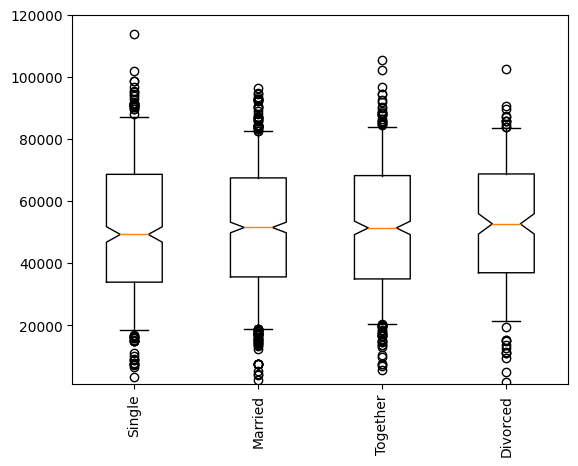

In [427]:
single = campaign['Marital_Status'] == 'Single'
married = campaign['Marital_Status'] == 'Married' 
together = campaign['Marital_Status'] == 'Together'
divorced = campaign['Marital_Status'] == 'Divorced'

nic=plt.boxplot(np.array([campaign[single].Income, campaign[married].Income, campaign[together].Income, campaign[divorced].Income],dtype=object),
                notch=True,
                whis=(5, 95))
plt.xticks([ 1, 2, 3, 4], ['Single','Married','Together', 'Divorced'],rotation=90)
plt.ylim([1000, 120000])
plt.grid(False)
plt.show()

Nothing really interesting found here. Only marginal differences, whose edge lies in the hands of people within or past a relationship. A difference that could likely be explained away with age.

For our last look at income irrespective of spending, we shall take a quick look at distributions of income by level of education. Unsurprisingly, we do find that higher level of achieved education equates to higher income.

In [428]:
campaign.groupby('Education')[['Income']].aggregate(['mean', 'median', 'sum', 'count'])

Income                           
                    mean   median         sum count
Education                                          
2n Cycle    47688.591133  46891.0   9680784.0   203
Basic       20306.259259  20744.0   1096538.0    54
Graduation  52162.054174  51594.0  58734473.0  1126
Master      52896.783784  51044.5  19571810.0   370
PhD         56096.308642  55005.0  27262806.0   486

So here is what we've learned so far:
 - Fewer children equates to higher income
 - We're unlikely to see income over 70 000
 - University-level educated people earn significantly more than those without degrees
 - Ongoing relationship or past comitted relationship is indicative of higher income

Let us now get an overview of what kind of purchases what groups are more likely to make, along with their overall purchase aggregates.

In [429]:
campaign['TotalPurchases'] = campaign[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].sum(axis=1)

In [430]:
campaign.groupby('Marital_Status')[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'TotalPurchases']].aggregate(['mean', 'median', 'sum', 'count'])

NumDealsPurchases                    NumWebPurchases         \
                            mean median   sum count            mean median   
Marital_Status                                                               
Absurd                  2.000000    2.0     4     2        3.500000    3.5   
Alone                   3.666667    4.0    11     3        5.000000    3.0   
Divorced                2.435345    2.0   565   232        4.310345    4.0   
Married                 2.392361    2.0  2067   864        4.087963    4.0   
Single                  2.131250    1.0  1023   480        3.872917    3.0   
Together                2.321244    2.0  1344   579        4.082902    4.0   
Widow                   2.337662    2.0   180    77        4.623377    4.0   
YOLO                    5.000000    5.0    10     2        7.000000    7.0   

                           NumCatalogPurchases                     \
                 sum count                mean median   sum count   
Marital_Status                                                      
Absurd             7     2            7.500000    7.5    15     2   
Alone             15     3            0.666667    1.0     2     3   
Divorced        1000   232            2.672414    2.0   620   232   
Married         3532   864            2.625000    2.0  2268   864   
Single          1859   480            2.600000    2.0  1248   480   
Together        2364   579            2.678756    2.0  1551   579   
Widow            356    77            3.324675    3.0   256    77   
YOLO              14     2            1.000000    1.0     2     2   

               NumStorePurchases                    TotalPurchases         \
                            mean median   sum count           mean median   
Marital_Status                                                              
Absurd                  6.500000    6.5    13     2      19.500000   19.5   
Alone                   4.000000    4.0    12     3      13.333333   11.0   
Divorced                5.818966    5.0  1350   232      15.237069   16.0   
Married                 5.850694    5.0  5055   864      14.956019   15.0   
Single                  5.639583    4.0  2707   480      14.243750   14.0   
Together                5.740933    5.0  3324   579      14.823834   15.0   
Widow                   6.415584    6.0   494    77      16.701299   17.0   
YOLO                    6.000000    6.0    12     2      19.000000   19.0   

                             
                  sum count  
Marital_Status               
Absurd             39     2  
Alone              40     3  
Divorced         3535   232  
Married         12922   864  
Single           6837   480  
Together         8583   579  
Widow            1286    77  
YOLO               38     2

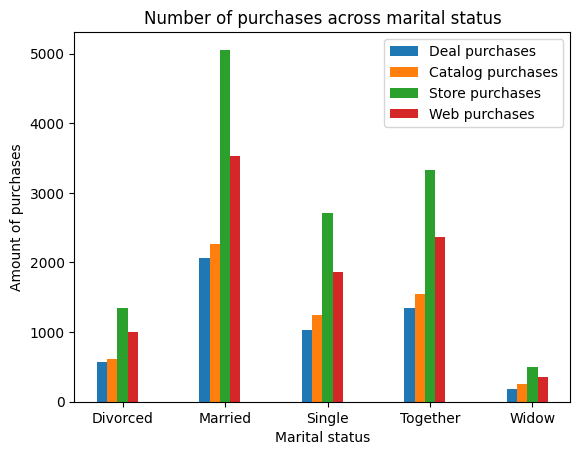

In [431]:
grouped = campaign.groupby('Marital_Status')[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'TotalPurchases']].aggregate(['sum', 'mean'])
X = ['Divorced', 'Married', 'Single', 'Together', 'Widow']
deal_purchases = [grouped.loc[('Divorced', 'NumDealsPurchases')]['sum'],grouped.loc[('Married', 'NumDealsPurchases')]['sum'],grouped.loc[('Single', 'NumDealsPurchases')]['sum'],grouped.loc[('Together', 'NumDealsPurchases')]['sum'], grouped.loc[('Widow', 'NumDealsPurchases')]['sum']]
web_purchases = [grouped.loc[('Divorced', 'NumWebPurchases')]['sum'],grouped.loc[('Married', 'NumWebPurchases')]['sum'],grouped.loc[('Single', 'NumWebPurchases')]['sum'],grouped.loc[('Together', 'NumWebPurchases')]['sum'], grouped.loc[('Widow', 'NumWebPurchases')]['sum']]
catalog_purchases = [grouped.loc[('Divorced', 'NumCatalogPurchases')]['sum'],grouped.loc[('Married', 'NumCatalogPurchases')]['sum'],grouped.loc[('Single', 'NumCatalogPurchases')]['sum'],grouped.loc[('Together', 'NumCatalogPurchases')]['sum'], grouped.loc[('Widow', 'NumCatalogPurchases')]['sum']]
store_purchases = [grouped.loc[('Divorced', 'NumStorePurchases')]['sum'],grouped.loc[('Married', 'NumStorePurchases')]['sum'],grouped.loc[('Single', 'NumStorePurchases')]['sum'],grouped.loc[('Together', 'NumStorePurchases')]['sum'], grouped.loc[('Widow', 'NumStorePurchases')]['sum']]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, deal_purchases, 0.1, label = 'Deal purchases')
plt.bar(X_axis - 0.1, catalog_purchases, 0.1, label = 'Catalog purchases')
plt.bar(X_axis, store_purchases, 0.1, label = 'Store purchases')
plt.bar(X_axis + 0.1, web_purchases, 0.1, label = 'Web purchases')
  
plt.xticks(X_axis, X)
plt.xlabel("Marital status")
plt.ylabel("Amount of purchases")
plt.title("Number of purchases across marital status")
plt.legend()
plt.show()

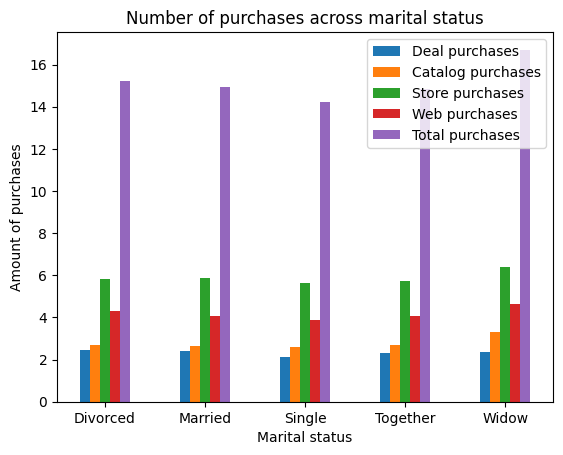

In [432]:
deal_purchases = [grouped.loc[('Divorced', 'NumDealsPurchases')]['mean'],grouped.loc[('Married', 'NumDealsPurchases')]['mean'],grouped.loc[('Single', 'NumDealsPurchases')]['mean'],grouped.loc[('Together', 'NumDealsPurchases')]['mean'], grouped.loc[('Widow', 'NumDealsPurchases')]['mean']]
web_purchases = [grouped.loc[('Divorced', 'NumWebPurchases')]['mean'],grouped.loc[('Married', 'NumWebPurchases')]['mean'],grouped.loc[('Single', 'NumWebPurchases')]['mean'],grouped.loc[('Together', 'NumWebPurchases')]['mean'], grouped.loc[('Widow', 'NumWebPurchases')]['mean']]
catalog_purchases = [grouped.loc[('Divorced', 'NumCatalogPurchases')]['mean'],grouped.loc[('Married', 'NumCatalogPurchases')]['mean'],grouped.loc[('Single', 'NumCatalogPurchases')]['mean'],grouped.loc[('Together', 'NumCatalogPurchases')]['mean'], grouped.loc[('Widow', 'NumCatalogPurchases')]['mean']]
store_purchases = [grouped.loc[('Divorced', 'NumStorePurchases')]['mean'],grouped.loc[('Married', 'NumStorePurchases')]['mean'],grouped.loc[('Single', 'NumStorePurchases')]['mean'],grouped.loc[('Together', 'NumStorePurchases')]['mean'], grouped.loc[('Widow', 'NumStorePurchases')]['mean']]
total_purchases = [grouped.loc[('Divorced', 'TotalPurchases')]['mean'],grouped.loc[('Married', 'TotalPurchases')]['mean'],grouped.loc[('Single', 'TotalPurchases')]['mean'],grouped.loc[('Together', 'TotalPurchases')]['mean'], grouped.loc[('Widow', 'TotalPurchases')]['mean']]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, deal_purchases, 0.1, label = 'Deal purchases')
plt.bar(X_axis - 0.1, catalog_purchases, 0.1, label = 'Catalog purchases')
plt.bar(X_axis, store_purchases, 0.1, label = 'Store purchases')
plt.bar(X_axis + 0.1, web_purchases, 0.1, label = 'Web purchases')
plt.bar(X_axis + 0.2, total_purchases, 0.1, label = 'Total purchases')
  
plt.xticks(X_axis, X)
plt.xlabel("Marital status")
plt.ylabel("Amount of purchases")
plt.title("Number of purchases across marital status")
plt.legend()
plt.show()

In [433]:
campaign.groupby('Education')[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'TotalPurchases']].aggregate(['mean', 'median', 'sum', 'count'])

NumDealsPurchases                    NumWebPurchases               \
                        mean median   sum count            mean median   sum   
Education                                                                      
2n Cycle            2.246305    2.0   456   203        3.729064    3.0   757   
Basic               1.796296    1.0    97    54        1.888889    2.0   102   
Graduation          2.308171    2.0  2599  1126        4.126110    4.0  4646   
Master              2.427027    2.0   898   370        4.032432    3.0  1492   
PhD                 2.374486    2.0  1154   486        4.423868    4.0  2150   

                 NumCatalogPurchases                    NumStorePurchases  \
           count                mean median   sum count              mean   
Education                                                                   
2n Cycle     203            2.320197    1.0   471   203          5.507389   
Basic         54            0.481481    0.0    26    54          2.851852   
Graduation  1126            2.727353    2.0  3071  1126          5.832149   
Master       370            2.570270    2.0   951   370          5.897297   
PhD          486            2.969136    2.0  1443   486          6.061728   

                              TotalPurchases                      
           median   sum count           mean median    sum count  
Education                                                         
2n Cycle      4.0  1118   203      13.802956   12.0   2802   203  
Basic         3.0   154    54       7.018519    6.0    379    54  
Graduation    5.0  6567  1126      14.993783   15.5  16883  1126  
Master        5.0  2182   370      14.927027   15.0   5523   370  
PhD           5.0  2946   486      15.829218   17.0   7693   486

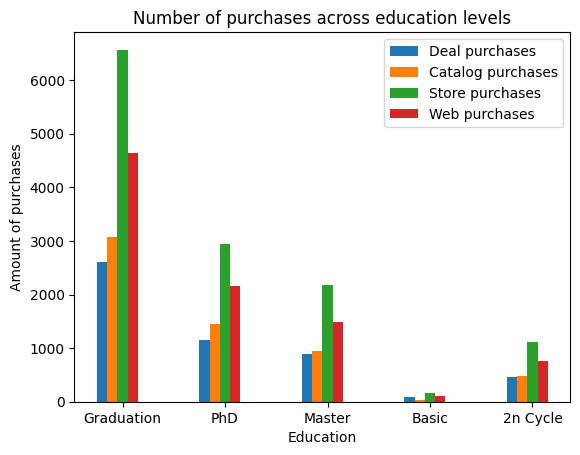

In [434]:
grouped = campaign.groupby('Education')[['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'TotalPurchases']].aggregate(['sum', 'mean'])
X = campaign['Education'].unique()
deal_purchases = [grouped.loc[('Graduation', 'NumDealsPurchases')]['sum'],grouped.loc[('PhD', 'NumDealsPurchases')]['sum'],grouped.loc[('Master', 'NumDealsPurchases')]['sum'],grouped.loc[('Basic', 'NumDealsPurchases')]['sum'], grouped.loc[('2n Cycle', 'NumDealsPurchases')]['sum']]
web_purchases = [grouped.loc[('Graduation', 'NumWebPurchases')]['sum'],grouped.loc[('PhD', 'NumWebPurchases')]['sum'],grouped.loc[('Master', 'NumWebPurchases')]['sum'],grouped.loc[('Basic', 'NumWebPurchases')]['sum'], grouped.loc[('2n Cycle', 'NumWebPurchases')]['sum']]
catalog_purchases = [grouped.loc[('Graduation', 'NumCatalogPurchases')]['sum'],grouped.loc[('PhD', 'NumCatalogPurchases')]['sum'],grouped.loc[('Master', 'NumCatalogPurchases')]['sum'],grouped.loc[('Basic', 'NumCatalogPurchases')]['sum'], grouped.loc[('2n Cycle', 'NumCatalogPurchases')]['sum']]
store_purchases = [grouped.loc[('Graduation', 'NumStorePurchases')]['sum'],grouped.loc[('PhD', 'NumStorePurchases')]['sum'],grouped.loc[('Master', 'NumStorePurchases')]['sum'],grouped.loc[('Basic', 'NumStorePurchases')]['sum'], grouped.loc[('2n Cycle', 'NumStorePurchases')]['sum']]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, deal_purchases, 0.1, label = 'Deal purchases')
plt.bar(X_axis - 0.1, catalog_purchases, 0.1, label = 'Catalog purchases')
plt.bar(X_axis, store_purchases, 0.1, label = 'Store purchases')
plt.bar(X_axis + 0.1, web_purchases, 0.1, label = 'Web purchases')
  
plt.xticks(X_axis, X)
plt.xlabel("Education")
plt.ylabel("Amount of purchases")
plt.title("Number of purchases across education levels")
plt.legend()
plt.show()

It is plain to see that most of our revenue comes from graduates, who overwhelmingly buy in stores. It does not, however, tell us, if an individual Graduate is more likely to purchase our product.

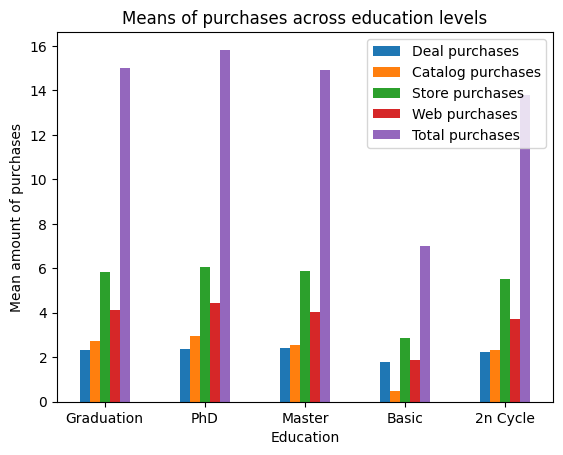

In [435]:
deal_purchases = [grouped.loc[('Graduation', 'NumDealsPurchases')]['mean'],grouped.loc[('PhD', 'NumDealsPurchases')]['mean'],grouped.loc[('Master', 'NumDealsPurchases')]['mean'],grouped.loc[('Basic', 'NumDealsPurchases')]['mean'], grouped.loc[('2n Cycle', 'NumDealsPurchases')]['mean']]
web_purchases = [grouped.loc[('Graduation', 'NumWebPurchases')]['mean'],grouped.loc[('PhD', 'NumWebPurchases')]['mean'],grouped.loc[('Master', 'NumWebPurchases')]['mean'],grouped.loc[('Basic', 'NumWebPurchases')]['mean'], grouped.loc[('2n Cycle', 'NumWebPurchases')]['mean']]
catalog_purchases = [grouped.loc[('Graduation', 'NumCatalogPurchases')]['mean'],grouped.loc[('PhD', 'NumCatalogPurchases')]['mean'],grouped.loc[('Master', 'NumCatalogPurchases')]['mean'],grouped.loc[('Basic', 'NumCatalogPurchases')]['mean'], grouped.loc[('2n Cycle', 'NumCatalogPurchases')]['mean']]
store_purchases = [grouped.loc[('Graduation', 'NumStorePurchases')]['mean'],grouped.loc[('PhD', 'NumStorePurchases')]['mean'],grouped.loc[('Master', 'NumStorePurchases')]['mean'],grouped.loc[('Basic', 'NumStorePurchases')]['mean'], grouped.loc[('2n Cycle', 'NumStorePurchases')]['mean']]
total_purchases = [grouped.loc[('Graduation', 'TotalPurchases')]['mean'],grouped.loc[('PhD', 'TotalPurchases')]['mean'],grouped.loc[('Master', 'TotalPurchases')]['mean'],grouped.loc[('Basic', 'TotalPurchases')]['mean'], grouped.loc[('2n Cycle', 'TotalPurchases')]['mean']]

X_axis = np.arange(len(X))
  
plt.bar(X_axis - 0.2, deal_purchases, 0.1, label = 'Deal purchases')
plt.bar(X_axis - 0.1, catalog_purchases, 0.1, label = 'Catalog purchases')
plt.bar(X_axis, store_purchases, 0.1, label = 'Store purchases')
plt.bar(X_axis + 0.1, web_purchases, 0.1, label = 'Web purchases')
plt.bar(X_axis + 0.2, total_purchases, 0.1, label = 'Total purchases')
  
plt.xticks(X_axis, X)
plt.xlabel("Education")
plt.ylabel("Mean amount of purchases")
plt.title("Means of purchases across education levels")
plt.legend()
plt.show()

So what did we learn from this?
 - Graduates and married people make up the majority of our sales
 - Most sales occur in physical stores, followed by web-based sales and sales generated by catalogs.
 - PhD students and widows are most likely to make a purchase

With this in mind, let's take a closer look at what overlap there is within these groups, and what kind of product they are most likely to purchase.

<Axes: xlabel='Education', ylabel='Count'>

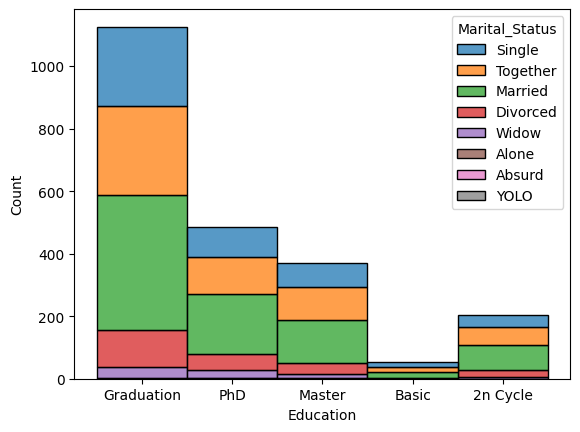

In [436]:
sns.histplot(binwidth=0.5, x="Education", hue="Marital_Status", data=campaign, stat="count", multiple="stack")

Luckily for us, it would seem that both of biggest groups of buyers - Married people and Graduates - not only have a large intersection with one another, but also have fairly large intersections with our most likely buyers - PhD students and Widows. Now to what kinds of product they are most likely to buy:

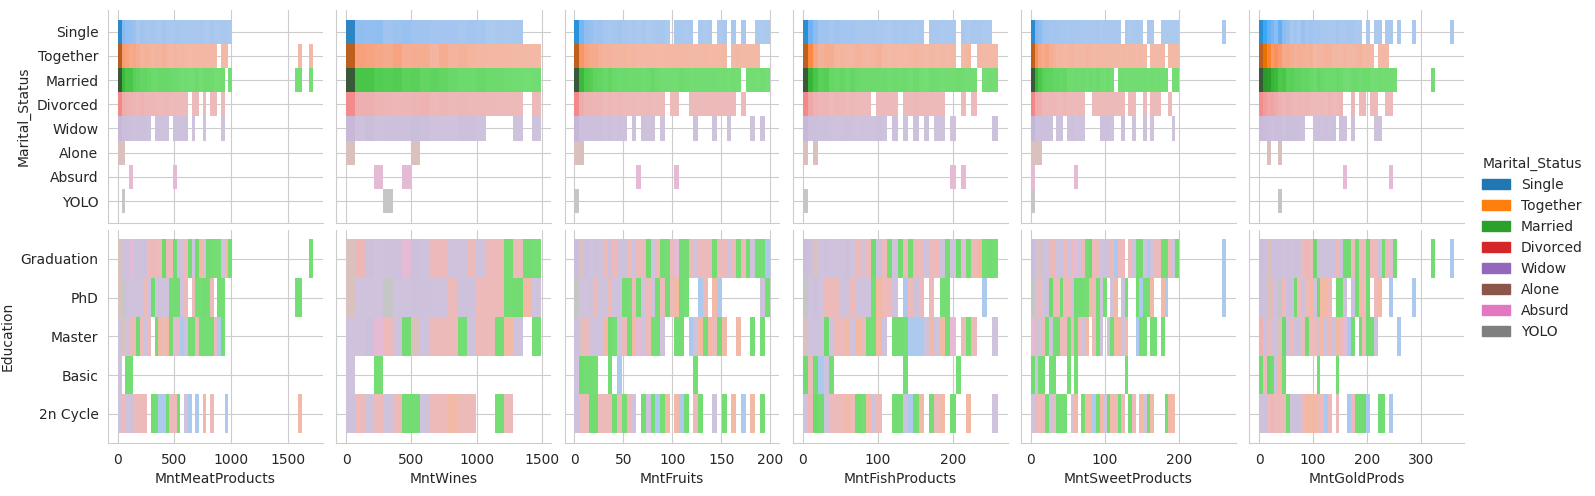

In [437]:
with sns.axes_style(style='whitegrid'):#{darkgrid, whitegrid, dark, white, ticks}
    sns.pairplot(data=campaign, x_vars=['MntMeatProducts','MntWines','MntFruits','MntFishProducts','MntSweetProducts','MntGoldProds'], y_vars=['Marital_Status', 'Education'], height=2.5, kind='hist', hue='Marital_Status')
plt.show()

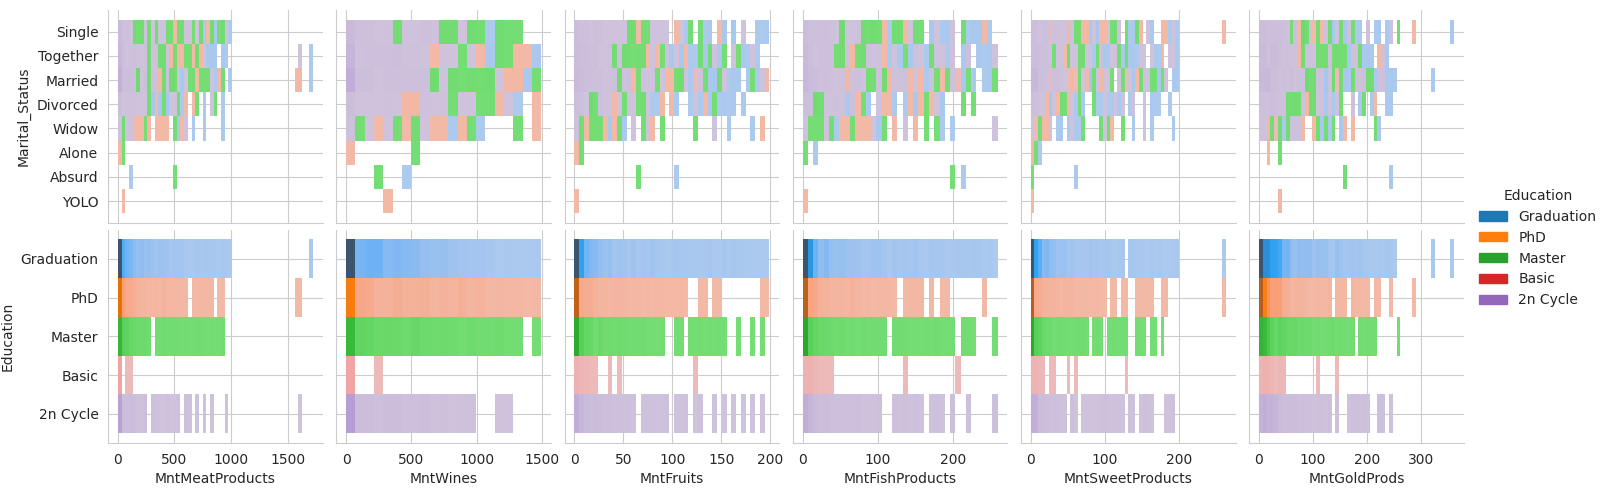

In [438]:
with sns.axes_style(style='whitegrid'):#{darkgrid, whitegrid, dark, white, ticks}
    sns.pairplot(data=campaign, x_vars=['MntMeatProducts','MntWines','MntFruits','MntFishProducts','MntSweetProducts','MntGoldProds'], y_vars=['Marital_Status', 'Education'], height=2.5, kind='hist', hue='Education')
plt.show()

It is plain to see that the most popular product is alcohol, with only meat products lagging even close behind the sheer amount of sold wine.Funnily enough, widows really are a solid chunk of our sold wine, along with married people.

# Conclusion

We have found a number of interesting results. Should future campaigns wonder about what kind of customer or product they should target, here is some advice:
 - Store and web-based purchases make up the majority of sales, especially among our biggest spenders
 - Wine and Meat products are by far most popular
 - There is no point in marketing just about anything to people with only Basic education
 - Childless adults tend to be wealthier
 - Marketing to married graduates is appealing to the largest demographic of big spenders
 - Widows are to be welcomed with fanfare
 - Most small purchases will be made by people with only 2nd Cycle of their education finished
 - PhD students and Married people tend to buy in bulk

**Author:** *Martin Gráf*